<a href="https://colab.research.google.com/github/aarontjoseph94/ENEL645-Assignments/blob/TA%2F2-1-2/assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645_assignment02_team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team_(team number)_FCN.h5 (fully connected model) and team_(team number)_FCN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

## 1. Load your data

In [2]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

In [3]:
# Use this space to explore you datasets
# Create additional cells as you see fit
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

## 3. Represent your labels using one hot encoding

In [4]:
from tensorflow.keras.utils import to_categorical
Y_train_oh = to_categorical(Y_train)
Y_val_oh = to_categorical(Y_val)
Y_test_oh = to_categorical(Y_test)

## 4. Data scaling and Data augmentation

In [5]:
# Experiment with different data scaling methods
norm_type = 1 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

In [6]:
# Create your data augmentation object to improve training
# set your batch size
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [10]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected(ishape=(32, 32, 3), k=10, lr=1e-4, drop=0.1):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    model_dense_1 = tf.keras.layers.Dense(256, activation='relu')(model_input_flatten)
    model_drop_1 = tf.keras.layers.Dropout(rate=drop)(model_dense_1)
    model_dense_2 = tf.keras.layers.Dense(256, activation='relu')(model_drop_1)
    model_drop_2 = tf.keras.layers.Dropout(rate=drop)(model_dense_2)
    model_dense_3 = tf.keras.layers.Dense(256, activation='relu')(model_drop_2)
    model_drop_3 = tf.keras.layers.Dropout(rate=drop)(model_dense_3)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(model_drop_3)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

## 6. Define your callbacks (save your model, patience, etc.)

In [8]:
model_name_fcn = "team_48_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [11]:
model = my_model_fully_connected()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               786688    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792 

In [12]:
# train your model - decide for how many epochs
model.fit(train_flow, epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/100
1172/1172 [==============================] - 37s 31ms/step - loss: 2.0116 - accuracy: 0.2725 - val_loss: 1.7469 - val_accuracy: 0.3776
Epoch 2/100
1172/1172 [==============================] - 37s 31ms/step - loss: 1.7842 - accuracy: 0.3587 - val_loss: 1.6778 - val_accuracy: 0.4083
Epoch 3/100
1172/1172 [==============================] - 36s 31ms/step - loss: 1.7051 - accuracy: 0.3874 - val_loss: 1.6365 - val_accuracy: 0.4174
Epoch 4/100
1172/1172 [==============================] - 36s 30ms/step - loss: 1.6729 - accuracy: 0.3964 - val_loss: 1.6047 - val_accuracy: 0.4294
Epoch 5/100
1172/1172 [==============================] - 36s 31ms/step - loss: 1.6256 - accuracy: 0.4193 - val_loss: 1.5709 - val_accuracy: 0.4419
Epoch 6/100
1172/1172 [==============================] - 36s 30ms/step - loss: 1.6091 - accuracy: 0.4247 - val_loss: 1.5584 - val_accuracy: 0.4526
Epoch 7/100
1172/1172 [==============================] - 36s 30ms/step - loss: 1.5937 - accuracy: 0.4278 - val_loss: 1

## 8. Test your model

313/313 [==============================] - 1s 4ms/step - loss: 1.3820 - accuracy: 0.5132


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4868


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

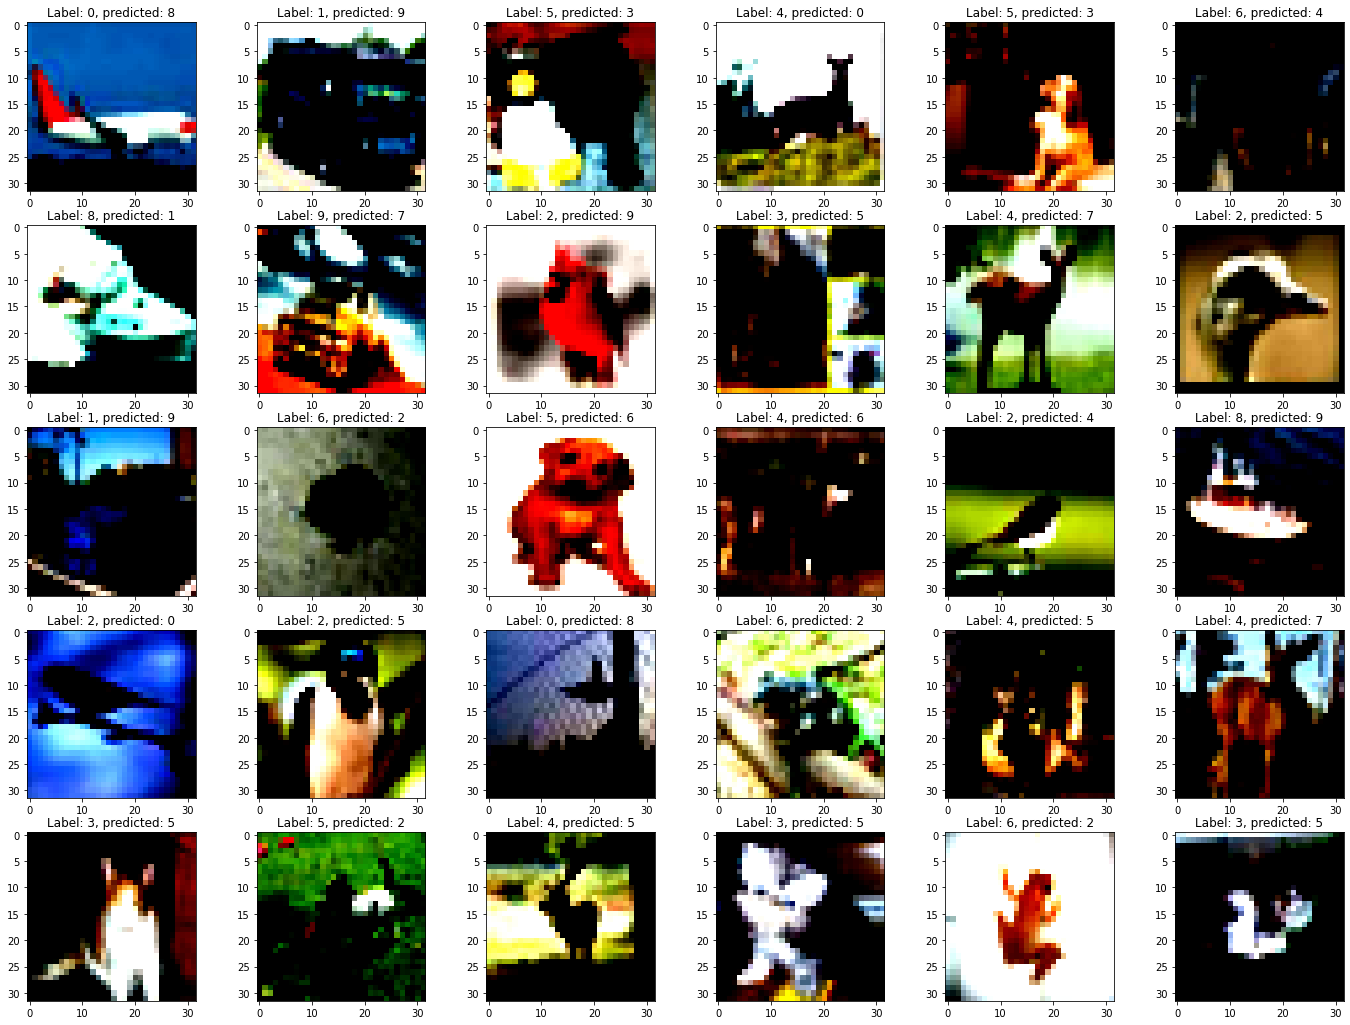

In [13]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [14]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn(ishape=(32, 32, 3), d=2, k=10, lr=1e-3, drop=0.1):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_conv_1 = tf.keras.layers.Conv2D(16, 3, activation='relu', dilation_rate=d, padding='same')(model_input)
    model_pooling_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(model_conv_1)
    model_conv_2 = tf.keras.layers.Conv2D(32, 3, activation='relu', dilation_rate=d, padding='same')(model_pooling_1)
    model_pooling_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(model_conv_2)
    model_conv_3 = tf.keras.layers.Conv2D(64, 3, activation='relu', dilation_rate=d, padding='same')(model_pooling_2)
    model_pooling_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(model_conv_3)
    model_conv_flatten = tf.keras.layers.Flatten()(model_pooling_3)
    model_dense_1 = tf.keras.layers.Dense(256, activation='relu')(model_conv_flatten)
    model_drop_1 = tf.keras.layers.Dropout(rate=drop)(model_dense_1)
    model_dense_2 = tf.keras.layers.Dense(256, activation='relu')(model_drop_1)
    model_drop_2 = tf.keras.layers.Dropout(rate=drop)(model_dense_2)
    model_dense_3 = tf.keras.layers.Dense(256, activation='relu')(model_drop_2)
    model_drop_3 = tf.keras.layers.Dropout(rate=drop)(model_dense_3)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(model_drop_3)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

## 6. Define your callbacks (save your model, patience, etc.)

In [15]:
model_name_cnn = "team_48_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [16]:
model = my_model_cnn()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0   

In [17]:
# train your model - decide for how many epochs
model.fit(train_flow, epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/100
1172/1172 [==============================] - 95s 80ms/step - loss: 1.8534 - accuracy: 0.3133 - val_loss: 1.5636 - val_accuracy: 0.4406
Epoch 2/100
1172/1172 [==============================] - 89s 76ms/step - loss: 1.4429 - accuracy: 0.4783 - val_loss: 1.3092 - val_accuracy: 0.5239
Epoch 3/100
1172/1172 [==============================] - 89s 76ms/step - loss: 1.3136 - accuracy: 0.5330 - val_loss: 1.2478 - val_accuracy: 0.5524
Epoch 4/100
1172/1172 [==============================] - 90s 77ms/step - loss: 1.2381 - accuracy: 0.5641 - val_loss: 1.2292 - val_accuracy: 0.5588
Epoch 5/100
1172/1172 [==============================] - 87s 74ms/step - loss: 1.1339 - accuracy: 0.5968 - val_loss: 1.1145 - val_accuracy: 0.6076
Epoch 6/100
1172/1172 [==============================] - 87s 74ms/step - loss: 1.0668 - accuracy: 0.6205 - val_loss: 1.0899 - val_accuracy: 0.6152
Epoch 7/100
1172/1172 [==============================] - 90s 77ms/step - loss: 1.0472 - accuracy: 0.6300 - val_loss: 1

## 8. Test your model

313/313 [==============================] - 5s 16ms/step - loss: 0.8686 - accuracy: 0.7032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

2968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

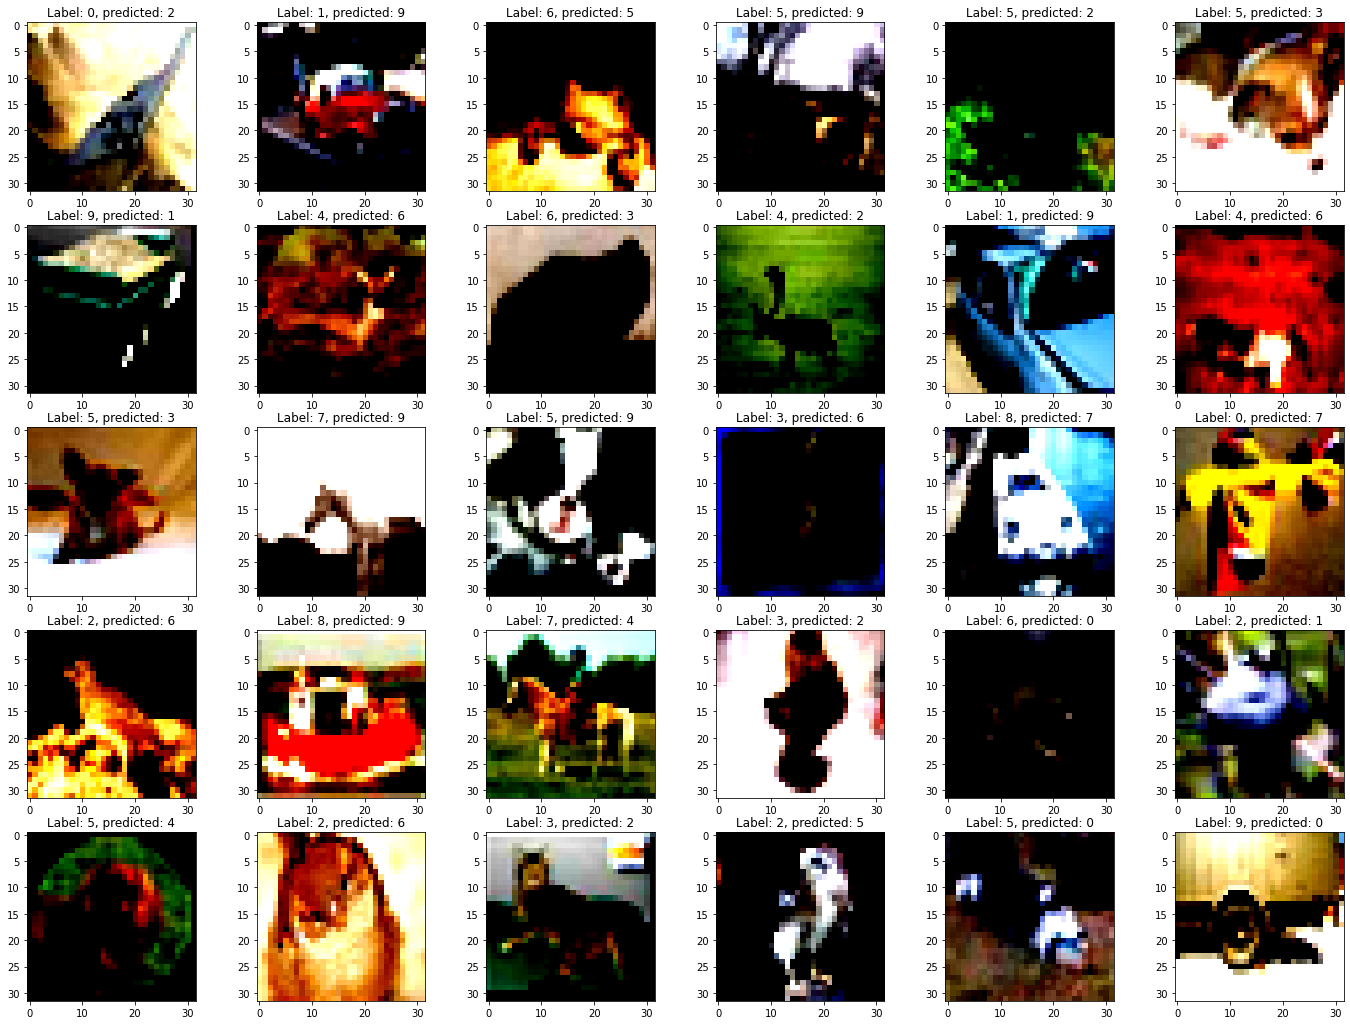

In [18]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...